# Decoder and PHATE idea


In [1]:
import phate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances

In [2]:
import numpy as np
import plotly.graph_objects as go

def random_spherical_noise(center, radius, n):
    """Generate random points near a center point on the sphere."""
    noise = []
    for _ in range(n):
        vec = center + 0.15 * np.random.randn(3)  # small 3D Gaussian noise
        vec /= np.linalg.norm(vec)  # reproject onto sphere
        noise.append(vec)
    return np.array(noise)

def generate_branch(start, direction, steps, arc_length):
    """Generate an arc of points along a branch with some spread."""
    tangent = direction / np.linalg.norm(direction)
    arc = []
    for theta in np.linspace(0, arc_length, steps):
        axis = np.cross(start, tangent)
        axis /= np.linalg.norm(axis)

        # Rodrigues rotation
        point = (start * np.cos(theta) +
                 np.cross(axis, start) * np.sin(theta) +
                 axis * np.dot(axis, start) * (1 - np.cos(theta)))
        point /= np.linalg.norm(point)

        # Add local branch noise
        noise = 0.03 * np.random.randn(3)
        noise -= np.dot(noise, point) * point  # remove radial component
        point += noise
        point /= np.linalg.norm(point)
        arc.append(point)
    return np.array(arc)

# Root cluster
root_center = np.array([0, 0, 1])

root_cluster = random_spherical_noise(root_center, radius=1, n=15000)

# Directions for 3 branches
branch_dirs = [
    np.array([1.5, 1.0, -0.5]),
    np.array([-1.0, 1.0, -0.5]),
    np.array([0.5, -1.5, -0.5])
]

branches = []
terminal_clusters = []
branch_labels = []

for i, dir_vec in enumerate(branch_dirs):
    branch = generate_branch(root_center, dir_vec, steps=600, arc_length=np.pi/2)
    branches.append(branch)
    branch_labels.extend([i + 1] * len(branch))

    # Terminal cluster at end of arc
    term_center = branch[-2]
    terminal = random_spherical_noise(term_center, radius=0.1, n=5000)
    terminal_clusters.append(terminal)
    branch_labels.extend([i + 1] * len(terminal))

# Combine all data
X = np.vstack([root_cluster] + branches + terminal_clusters)
labels = np.array([0]*len(root_cluster) + branch_labels)

# Plot
fig = go.Figure(data=go.Scatter3d(
    x=X[:, 0], y=X[:, 1], z=X[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color=labels,
        colorscale='Viridis',
        opacity=0.9
    )
))
fig.update_layout(
    title='Simulated Differentiation: Root → 3 Branches on Sphere',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()


In [ ]:
phate_op = phate.PHATE(
    t=20,
    knn=10,
    decay=40,
    n_landmark=None,  # still use all 8000 points, no subsampling
    random_state=42
)

# Slice the first 8000 rows
phate_op.fit(X)

embedding_2D = phate_op.fit_transform(X)

Running PHATE on 31800 observations and 3 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 1.04 seconds.
  Calculating affinities...
  Calculated affinities in 0.13 seconds.
Calculated graph and diffusion operator in 1.18 seconds.
Calculating PHATE...
  Running PHATE on 31800 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.11 seconds.
  Calculated graph and diffusion operator in 1.14 seconds.
  Calculating diffusion potential...


In [31]:
from scipy.sparse.linalg import eigs  # sparse and partial eigendecomposition

# Extract diffusion operator P
P = phate_op.diff_op

# Efficient power operation through matrix-vector multiplication
def matvec_power(v):
    x = v
    for _ in range(phate_op.t):
        x = P @ x
    return x

# Wrap in a linear operator to avoid explicit P^t
from scipy.sparse.linalg import LinearOperator

n = P.shape[0]
P_t_linop = LinearOperator((n, n), matvec=matvec_power, dtype=np.float64)

# Get top 3 eigenpairs of P^t (skip the trivial 1st)
eigvals, eigvecs = eigs(P_t_linop, k=3, which='LR')  # 'LR' = largest real part

# Sort and take real part
idx = np.argsort(-np.abs(eigvals))
eigvals = eigvals[idx].real
eigvecs = eigvecs[:, idx].real

# Create 2D embedding
embedding_2D = eigvecs[:, 1:3] * eigvals[1:3]

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(embedding_2D[:, 0], embedding_2D[:, 1], s=10, alpha=0.8)
plt.title("Efficient 2D Diffusion Embedding from PHATE $P^t$")
plt.xlabel("Diffusion Component 1")
plt.ylabel("Diffusion Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

# --- Step 0: Assume these are already defined ---
# embedding_2D: (n_samples, 2) - your intrinsic manifold coords (from PHATE eigendecomposition)
# X: (n_samples, 5) - your high-dimensional data

# Simulate them here for demo purposes — replace with real values

# --- Step 1: Define decoder model: R^2 → R^5 ---
latent_input = layers.Input(shape=(2,))
x = layers.Dense(64, activation='relu')(latent_input)
x = layers.Dense(128, activation='relu')(x)
x_output = layers.Dense(3)(x)

decoder = Model(inputs=latent_input, outputs=x_output)

# --- Step 2: Define custom loss with distance preservation ---
def distance_preserving_loss(x_true, x_pred, z_batch, lambda_dist=1.0):
    # Reconstruction loss
    recon_loss = tf.reduce_mean(tf.square(x_true - x_pred))

    # Pairwise distances in latent and decoded spaces
    z_dist = tf.norm(tf.expand_dims(z_batch, axis=1) - tf.expand_dims(z_batch, axis=0), axis=-1)
    x_dist = tf.norm(tf.expand_dims(x_pred, axis=1) - tf.expand_dims(x_pred, axis=0), axis=-1)

    # Distance preservation loss
    dist_loss = tf.reduce_mean(tf.square(x_dist - z_dist))

    return recon_loss + lambda_dist * dist_loss

# --- Step 3: Custom training loop ---
optimizer = tf.keras.optimizers.Adam()
loss_history = []

z_tensor = tf.convert_to_tensor(embedding_2D, dtype=tf.float32)
x_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
for epoch in range(100):
    with tf.GradientTape() as tape:
        x_pred = decoder(z_tensor)
        loss = distance_preserving_loss(x_tensor, x_pred, z_tensor, lambda_dist=1.0)
    grads = tape.gradient(loss, decoder.trainable_weights)
    optimizer.apply_gradients(zip(grads, decoder.trainable_weights))
    loss_history.append(loss.numpy())


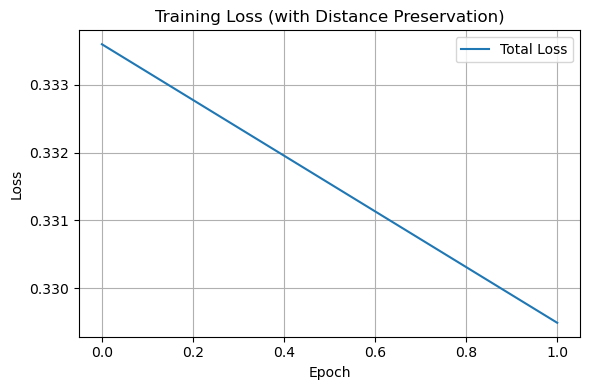

In [27]:

# --- Step 4: Plot training loss ---
plt.figure(figsize=(6, 4))
plt.plot(loss_history, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (with Distance Preservation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


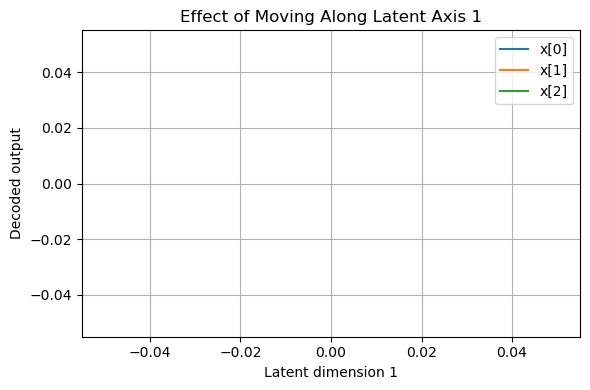

In [28]:
# --- Step 5: Plot decoded variation along latent axis 1 ---
z_grid = np.linspace(-3, 3, 100)
z_probe = np.stack([z_grid, np.zeros_like(z_grid)], axis=1)
decoded = decoder.predict(z_probe)

plt.figure(figsize=(6, 4))
for i in range(3):
    plt.plot(z_grid, decoded[:, i], label=f"x[{i}]")
plt.xlabel("Latent dimension 1")
plt.ylabel("Decoded output")
plt.title("Effect of Moving Along Latent Axis 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# --- Step 6: Jacobian at a single point ---
z_sample = tf.convert_to_tensor(embedding_2D[:1], dtype=tf.float32)  # first point
with tf.GradientTape() as tape:
    tape.watch(z_sample)
    x_decoded = decoder(z_sample)
jacobian = tape.batch_jacobian(x_decoded, z_sample)

print("Decoded 5D vector:", x_decoded.numpy())
print("Jacobian shape:", jacobian.shape)  # Should be (1, 5, 2)

Decoded 5D vector: [[nan nan nan]]
Jacobian shape: (1, 3, 2)
